In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.signal as signal
import peakutils
import wfdb
from wfdb import processing
import ecg_plot
import ast
import neurokit2 as nk

from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Flatten, Conv2D

Load the raw data. The below cell has been taken from the example script in the PTB-XL dataset to load the data.

## Section 1: Loading the data and EDA

### Part 1.1: Loading the raw data

In [65]:
#Load raw_signals in array format
raw_signals = np.load('../data/ptb_raw_signals.npz')
raw_signals = raw_signals['arr_0']

In [67]:
raw_signals[0:1]

array([[[-0.119, -0.055,  0.064, ..., -0.026, -0.039, -0.079],
        [-0.116, -0.051,  0.065, ..., -0.031, -0.034, -0.074],
        [-0.12 , -0.044,  0.076, ..., -0.028, -0.029, -0.069],
        ...,
        [ 0.069,  0.   , -0.069, ...,  0.024, -0.041, -0.058],
        [ 0.086,  0.004, -0.081, ...,  0.242, -0.046, -0.098],
        [ 0.022, -0.031, -0.054, ...,  0.143, -0.035, -0.12 ]]])

In [93]:
#Load raw_signals that were converted to dataframe
signals_df = pd.read_csv('../data/ptb_signals_df')

In [94]:
signals_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079
1,-0.116,-0.051,0.065,0.083,-0.090,0.006,-0.064,-0.036,-0.003,-0.031,-0.034,-0.074
2,-0.120,-0.044,0.076,0.082,-0.098,0.016,-0.058,-0.034,-0.010,-0.028,-0.029,-0.069
3,-0.117,-0.038,0.080,0.077,-0.098,0.021,-0.050,-0.030,-0.015,-0.023,-0.022,-0.064
4,-0.103,-0.031,0.072,0.066,-0.087,0.021,-0.045,-0.027,-0.020,-0.019,-0.018,-0.058


In [7]:
# Load scp_statements.csv for diagnostic aggregation, i.e. reduce diagnostic classes to 6 superclasses
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
meta_data_df['diagnostic_superclass'] = meta_data_df.scp_codes.apply(aggregate_diagnostic)

Let's check the meta_data_df's diagnostic superclass

In [8]:
meta_data_df['diagnostic_superclass']

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21837, dtype: object

It seems to be a list

In [9]:
#Convert the list to a string. While running this, I ran into errors. There seems to have been empty strings
#With no diagnoses. So convert empty lists to 'NO_DIAG', for no diagnosis
for i in range(1,len(meta_data_df['diagnostic_superclass'])+1):
    try:
        meta_data_df['diagnostic_superclass'][i] = meta_data_df['diagnostic_superclass'][i][0]
    except:
        meta_data_df['diagnostic_superclass'][i] = 'NO_DIAG'

<ipython-input-9-ad8a7d45a2ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data_df['diagnostic_superclass'][i] = meta_data_df['diagnostic_superclass'][i][0]
<ipython-input-9-ad8a7d45a2ad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data_df['diagnostic_superclass'][i] = 'NO_DIAG'


In [10]:
meta_data_df['diagnostic_superclass']

ecg_id
1        NORM
2        NORM
3        NORM
4        NORM
5        NORM
         ... 
21833    STTC
21834    NORM
21835    STTC
21836    NORM
21837    NORM
Name: diagnostic_superclass, Length: 21837, dtype: object

How do our raw signals look like?

In [11]:
raw_signals.shape

(21837, 1000, 12)

There are 21837 rows of data...

...Each of 10 seconds (represented by 1000)...

...measuring the 12 leads of the 12-lead ecg (i.e. 12 variables)

Let's take a look at the data

In [12]:
raw_signals[21836][999]

array([ 0.166, -0.007, -0.173, -0.08 ,  0.17 , -0.09 ,  0.069,  0.291,
        0.178,  0.106,  0.047, -0.103])

raw_signals [21836] [999] refers to ecg number 21836 (the last one), on the 999th time period (10th second). The 12 float64s refers to the values of each lead of the 12-lead ecg.

Let's take a look at how one of these ecg plots look like

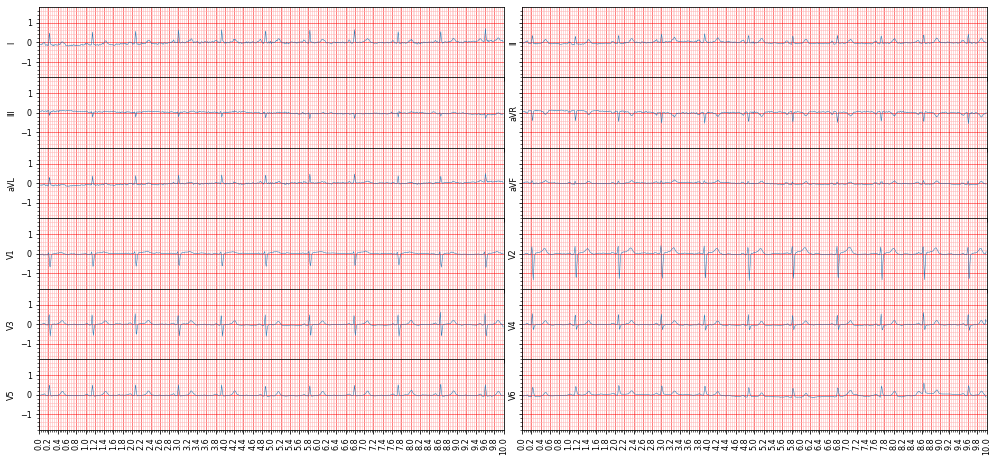

In [13]:
ecg_plot.plot_12(raw_signals[0].T, sample_rate=100, title='')
ecg_plot.show()

Saving this plot as a png

In [14]:
ecg_plot.save_as_png('example_ecg', '../data/data_images/')

### Part 1.2.1: Exploring the meta-data

Let's explore the classes and establish a baseline of model accuracy if we just guess the majority class

In [15]:
#Doing a count
meta_data_df['diagnostic_superclass'].value_counts()

NORM       9528
CD         4492
MI         3685
STTC       3016
HYP         709
NO_DIAG     407
Name: diagnostic_superclass, dtype: int64

In [16]:
#Get the mean of the value counts
meta_data_df['diagnostic_superclass'].value_counts().mean()

3639.5

In [17]:
#Get the percentage of the value counts
meta_data_df['diagnostic_superclass'].value_counts(normalize=True)*100

NORM       43.632367
CD         20.570591
MI         16.875029
STTC       13.811421
HYP         3.246783
NO_DIAG     1.863809
Name: diagnostic_superclass, dtype: float64

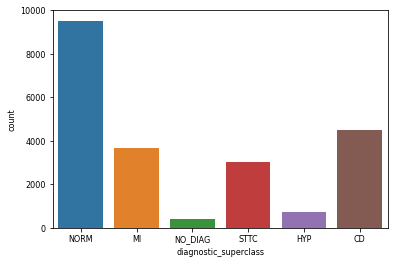

In [18]:
#Plotting the counts
sns.countplot(x = meta_data_df['diagnostic_superclass']);

It seems there is twice as many NORM heartbeats as the second most frequent class, STTC. MI follows closely behind, and there are even fewer NO_DIAG, HYP, and CD.

Put another way, there are 3 classes that are higher than the mean and 3 others that are way below the mean. NORM has about 2.5 times as many counts as the mean, while STTC and MI are about 1.4x as much. All this shows there's a severe imbalance in classes.

If we were to predict the majority class, NORM, we would be right 43.63% of the time.

In [19]:
meta_data_df.describe()

,patient_id,age,sex,height,weight,nurse,site,validated_by,strat_fold
count,21837.000000,21748.000000,21837.000000,6983.000000,9429.000000,20328.000000,21819.000000,12426.000000,21837.000000
mean,11255.005953,59.836307,0.478912,166.708292,70.997561,2.292503,1.547229,0.747948,5.505335
std,6234.132489,16.953125,0.499567,10.864935,15.875146,3.254786,4.169753,1.183269,2.875306
min,302.000000,2.000000,0.000000,6.000000,5.000000,0.000000,0.000000,0.000000,1.000000
25%,5982.000000,50.000000,0.000000,160.000000,60.000000,0.000000,0.000000,0.000000,3.000000
50%,11423.000000,62.000000,0.000000,166.000000,70.000000,1.000000,1.000000,1.000000,6.000000
75%,16614.000000,72.000000,1.000000,174.000000,80.000000,3.000000,2.000000,1.000000,8.000000
max,21797.000000,95.000000,1.000000,209.000000,250.000000,11.000000,50.000000,11.000000,10.000000


### Part 1.2.2: Exploring ECG data

I'm assuming you, the reader, do not have a background in reading an ecg.

We can treat the ecg as a landscape with markers on it. The shapes and patterns of these markers give us clues on the status of the patient's heart. These markers are called the **fiducial points**. If an ecg's fiducial points are healthy, we say the ecg is a sign of **normal sinus rhythm**.

Below is an example of an ecg's fiducial points that point to normal sinus rhythym.

![](../images/ecg_fiducial_points.PNG)
<p style="text-align: center;">An ecg of one heartbeat. The fiducial points all point to normal sinus rhythm. Taken from "Time-Domain Analysis of the Electrocardiogram", 2019, by Ioanna Chouvarda et al.</p>

A heartbeat begins when the **Denoisation**...

We want to take a look at the following features, taken from "Biomedical Signal Processing And Artificial Intelligence In Healthcare", pp. 106-107, 2020, by Walid Zgallai (ed.):

- **RR features**: The distance between R peaks and represents the length of time between heartbeats
- **Higher-Order statistics (HOS) features**: Where the ecg beat is segmented into _k_ segments and HOS statistics, like kurtosis and skewness, are calculated. This results in a 2 x _k_-dimensional feature for each beat
- **Local Binary Patterns (LBP) features**: ECG is one-dimensional time-series data, so a 1-dimensional LBP can be calculated for each data point in the segmented beat.
- **Wavelet features**: Using the discrete wavelet transform, we can extract wavelet features from the segmented ecg beats. Wavelet features have both spatial and temporal information from the QRS complex. Here, the wavelet transform is "applied to each beat signal using the Daubechies 3 family and a specific decomposition level. The approximation band coefficients are then used as wavelet features for the beat".

We have to first pre-process the data. Let's try this out on one patient's full, 10-second ecg data

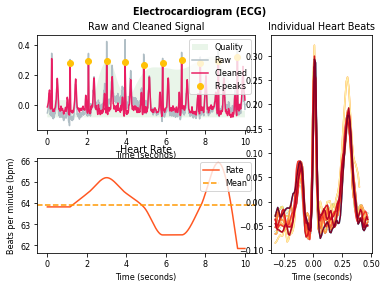

In [100]:
ecg_signals, info = nk.ecg_process(signals_df.iloc[0:1000,1], sampling_rate=100)
plot = nk.ecg_plot(ecg_signals, sampling_rate=100)

In [99]:
nk.ecg_intervalrelated(ecg_signals)


C:\Users\junho\anaconda3\lib\site-packages\neurokit2\signal\signal_psd.py:109: NeuroKitWarning: The duration of recording is too short to support a sufficiently long window for high frequency resolution. Consider using a longer recording or increasing the `min_frequency`
  warn(


,ECG_Rate_Mean,HRV_RMSSD,HRV_MeanNN,HRV_SDNN,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,...,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_ApEn,HRV_SampEn
0,63.916476,2.645751,94.0,2.0,2.77746,0.021277,0.028146,94.0,2.9652,0.031545,...,0.432646,0.567354,1.261554,1.444664,0.597965,0.402035,1.515176,1.242388,0.133531,-inf


Let's try the same process with a different lead from the same patient. We should get similar results since they are from the same ecg. Differences in values should be because of differences in measurement from the electrode placement and cleaning.

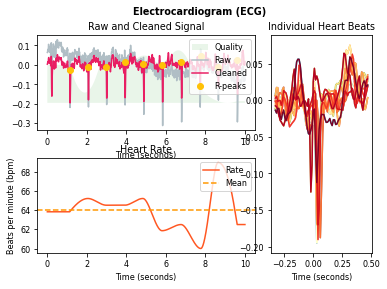

In [101]:
ecg_signals_2, info = nk.ecg_process(signals_df.iloc[0:1000,2], sampling_rate=100)
plot = nk.ecg_plot(ecg_signals_2, sampling_rate=100)

In [102]:
nk.ecg_intervalrelated(ecg_signals_2)


C:\Users\junho\anaconda3\lib\site-packages\neurokit2\signal\signal_psd.py:109: NeuroKitWarning: The duration of recording is too short to support a sufficiently long window for high frequency resolution. Consider using a longer recording or increasing the `min_frequency`
  warn(


,ECG_Rate_Mean,HRV_RMSSD,HRV_MeanNN,HRV_SDNN,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,...,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_ApEn,HRV_SampEn
0,64.004652,6.062178,94.0,3.741657,6.45866,0.039805,0.064491,93.0,4.4478,0.047826,...,0.731884,0.268116,2.685942,1.625687,0.518519,0.481481,2.828427,2.725541,0.133531,-inf


Let's detect the R_peaks from the first patient. R_peaks are best detected from lead 2, which is column 1 in the dataframe.

In [103]:
_, r_peaks = nk.ecg_peaks(ecg_signals, sampling_rate=100)

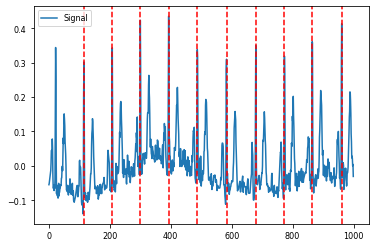

In [105]:
plot = nk.events_plot(r_peaks['ECG_R_Peaks'], signals_df.iloc[0:1000,1])

## Ideas going forward:

0. Find some statistical test that will allow me to compare the two means, e.g. ECG heart rate mean. Do I need some special test or can I do a standard test?
1. Get the features for each patient and save them into a new dataframe with id, which should correspond to patient id.
2. 

In [ ]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
meta_data_df['diagnostic_superclass'] = meta_data_df.scp_codes.apply(aggregate_diagnostic)

In [ ]:
meta_data_df['diagnostic_superclass']

In [ ]:
for i in range(1,len(meta_data_df['diagnostic_superclass'])+1):
    try:
        meta_data_df['diagnostic_superclass'][i] = meta_data_df['diagnostic_superclass'][i][0]
    except:
        meta_data_df['diagnostic_superclass'][i] = 'NO_DIAG'

In [ ]:
meta_data_df['diagnostic_superclass']

In [ ]:
ohe = pd.get_dummies(meta_data_df['diagnostic_superclass'], drop_first=True)

In [ ]:
#Concatenate the dummy variables df with Y and drop the diagnostic_superclass column
meta_data_df = pd.concat([meta_data_df, ohe], axis=1).drop(['diagnostic_superclass'], axis=1)

In [ ]:
#Check Y
meta_data_df.tail()

In [ ]:
# Split data into train and test
test_fold = 10

# Train
X_train = raw_signals[np.where(meta_data_df.strat_fold != test_fold)]
y_train = meta_data_df[(meta_data_df.strat_fold != test_fold)].iloc[:,-5:]

# Test
X_test = raw_signals[np.where(meta_data_df.strat_fold == test_fold)]
y_test = meta_data_df[meta_data_df.strat_fold == test_fold].iloc[:,-5:]

Let's build a first pass fully-connected neural network just to see what would happen. Let's give it 64 outputs in the first layer, 32 in the second, before flattening the data to fit the results, and an output layer of 5 categories.

In [ ]:
model = Sequential()

model.add(Dense(64, activation = 'relu', input_shape=(1000,12)))
model.add(Dense(32, activation='relu'))
model.add(Flatten())
model.add(Dense(5, activation= 'softmax'))

model.compile(loss = 'categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.summary()

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=512)

The model ends with an accuracy of around 0.2-0.25. If the model were given a few more epochs, we would probably end up with an accuracy of around 4.3-4.5.

This result is probably because of flattening the data